In [140]:
# !git clone -b siamese https://github.com/wagner1986/singular-points.git singular_points
# !pip install kornia e2cnn

# !pwd
# %cd /content/singular_points
# !pwd

In [141]:
import torch
from torch import nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

### Detector e Descritor

- computei o detector e descritor de um batch para criar massa de dados para a rede siamesa

In [142]:
import torch
from config import args, device
from predict.predict_utils import load_model_trained, predict_single_points,extract_features_with_box
import torchvision
from torchvision.transforms import transforms, InterpolationMode
from utils.my_dataset import FibersDataset, WoodsDataset
from utils import create_circular_mask
from matplotlib import pyplot as plt
import numpy as np
from training import KeyEqGroup, KeyPointsSelection
torch.__version__


def custom_config(args):
    args.img_size = 180
    args.dim_first = 2
    args.dim_second = 3
    args.dim_third = 4
    args.batch_size = 15
    args.margin_loss = 2.0
    args.border  = 15
    args.nms_size = 10 # normal é 10, alterei so pra avaliar o match
    args.box_size = 31
    args.exported = False
    return args


args = custom_config(args)
n_bin = 6
transform = transforms.Compose([
    transforms.Resize((args.img_size, args.img_size), interpolation=InterpolationMode.NEAREST),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

testset = torchvision.datasets.Flowers102(root='./data/datasets', split='test',
                                            download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=args.batch_size,
                                            shuffle=False, num_workers=2)




MODEL_PATH = "./data/models/model_flowers_ssim.pt"

single_point_model = load_model_trained(args,device,path=MODEL_PATH)
iterator=iter(testloader)
batch = next(iterator)
img_batch, labels =batch
print(len(img_batch),labels) #4

Já foi treinado
epoca 100 loss 3.5150668924930053
15 tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


### Segementa todas as features de batch só

pos predict  torch.Size([15, 1, 180, 180]) torch.Size([15, 1, 180, 180])


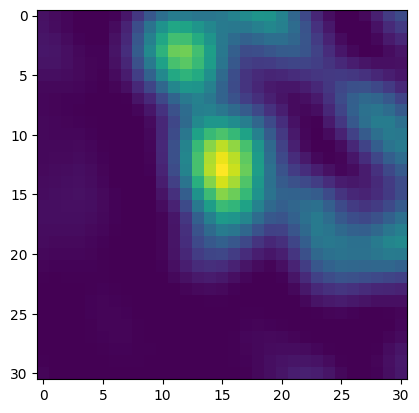

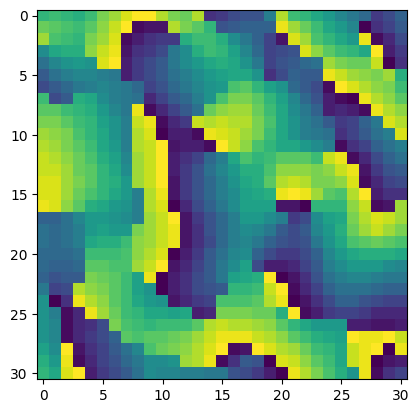

In [143]:
feature,orien1 = predict_single_points(single_point_model,batch)
batch_result,coords = extract_features_with_box(feature,orien1)

# concatena em um tensor somente as features e orientações
for i,(boxs,mini_feat_batch,mini_orien_batch) in enumerate(batch_result):
    if i==0:
        mini_feat_batch_concat = mini_feat_batch
        mini_orien_batch_concat = mini_orien_batch
    else:
        mini_feat_batch_concat = torch.cat([mini_feat_batch_concat,mini_feat_batch], dim=0)
        mini_orien_batch_concat = torch.cat([mini_orien_batch_concat,mini_orien_batch], dim=0)
    # print('batch ',i,mini_orien_batch_concat.shape)

mini_dataloader = torch.stack([mini_feat_batch_concat,mini_orien_batch_concat], dim=1)#TODO colocar orientacao depois

plt.imshow(mini_dataloader[0,0,:,:].cpu().detach())
plt.show()
plt.imshow(mini_dataloader[0,1,:,:].cpu().detach())
plt.show()

#### Dividi o array em batch de train e test de tamanho 10

In [144]:
import torch
from torch.utils.data import DataLoader, random_split

# Definindo o tamanho do lote desejado
batch_size = 10

# Dividindo o tensor em conjuntos de treinamento e teste
train_ratio = 0.8
train_size = int(train_ratio * len(mini_dataloader))
test_size = len(mini_dataloader) - train_size

train_tensor, test_tensor = random_split(mini_dataloader, [train_size, test_size])

# Criando os dataloaders para treinamento e teste
train_loader = DataLoader(train_tensor, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_tensor, batch_size=batch_size, shuffle=True)

# Verificando o tamanho dos conjuntos de treinamento e teste (em número de lotes)
print(len(train_loader))  # Saída: 64 (80% de 800 dividido por 10)
print(len(test_loader))  # Saída: 16 (20% de 800 dividido por 10)


99
25


### Define arquitetura do modelo de rede siamesa

In [145]:
from e2cnn import gspaces
from e2cnn import nn as enn    #the equivariant layer we need to build the model
from torch import nn
class Feature(nn.Module):
    def __init__(self,n_dim=30,n_channel=2) -> None:
        super().__init__()
        r2_act = gspaces.Rot2dOnR2(N=36)      

        feat_type_in  = enn.FieldType(r2_act,  n_channel*[r2_act.trivial_repr])
        feat_type_out = enn.FieldType(r2_act, 5*[r2_act.regular_repr])     
        self.input_type = feat_type_in

        self.block1 = enn.SequentialModule(
                enn.MaskModule(feat_type_in, n_dim, margin=2),
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=1, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True)
                )
        
        self.pool1 = enn.PointwiseAvgPoolAntialiased(feat_type_out, sigma=0.66, stride=1, padding=0)

        feat_type_in  = self.block1.out_type
        feat_type_out = enn.FieldType(r2_act, 1*[r2_act.regular_repr])
        self.block2 = enn.SequentialModule(                
                enn.R2Conv(feat_type_in, feat_type_out, kernel_size=5, padding=2, bias=False),
                enn.InnerBatchNorm(feat_type_out),
                enn.ReLU(feat_type_out, inplace=True),
                )
        # self.pool2 = enn.PointwiseAvgPool(feat_type_out, 21)
        self.gpool = enn.GroupPooling(feat_type_out)
        
                
    def forward(self,X1)->torch.Tensor:
        x = enn.GeometricTensor(X1, self.input_type)        
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        # x = self.pool2(x)
        x = self.gpool(x)   
        return x.tensor
    

class Discriminator(nn.Module):
    def __init__(self, n_classes=10) -> None:
        super().__init__()
        #criar camadas densa a partir de x que é uma cnn
        self.dense1 = nn.Linear(2*1*25*25, 256)
        self.dense2 = nn.Linear(256, 128)
        #função de ativação ideal para retornar um valor entre 0 e 1
        self.activation = nn.Sigmoid()

    
    def forward(self,X1,X2)->torch.Tensor:
        flatten_x1 = X1.view(X1.size(0), -1)
        flatten_x2 = X2.view(X2.size(0), -1)
      
        x = torch.cat((flatten_x1,flatten_x2),dim=1)
        x = self.dense1(x)
        x = self.dense2(x)
        # Calculando a diferença entre os embeddings
        # diff = flatten_x1 - flatten_x2
        # Calculando a distância euclidiana
        distance = torch.norm(x, dim=1)
        x = self.activation(distance)
        return x


class Siamesa(nn.Module):
    def __init__(self,n_dim=30,n_channel=2) -> None:
            super().__init__()
            self.feature = Feature(n_dim=n_dim,n_channel=n_channel)
            self.discriminator = Discriminator()
    
    def forward(self,X1,X2)->torch.Tensor:
        x1 = self.feature(X1)
        x2 = self.feature(X2)
        x = self.discriminator(x1,x2)
        return x
    

X1=torch.rand(8,2,31,31).to(device)
X2=torch.rand(8,2,31,31).to(device)

model =Siamesa(n_dim=31,n_channel=2).to(device)
temp = model(X1,X2)

temp


tensor([0.9957, 0.9956, 0.9954, 0.9969, 0.9948, 0.9941, 0.9948, 0.9943],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

### Metodos para o processo de treinamento

In [146]:
from tqdm import tqdm

#Create methods to train the model
def train_one_epoch(model,train_loader,optimizer,loss_fn,device='cpu'):
    model.train()
    total_loss = 0.

    for data in tqdm(train_loader, desc="Train "):
        data = data.to(device)
        optimizer.zero_grad()            

        #refactor block
        data_pos = random_transform(data)
        output_pos = model(data,data_pos)
        #sift rool data
        data_neg =torch.roll(data_pos, 1, 0)
        output_neg = model(data,data_neg)

        #calculate loss
        loss = loss_fn(output_pos,output_neg)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss/len(train_loader.dataset)

#Create methods to test the model
def test(model,test_loader,loss_fn,device='cpu'):
    model.eval()
    test_loss = 0.
    correct = 0.
    with torch.no_grad():
        for data in tqdm(test_loader, desc="Tests "):
            data = data.to(device)
            
            #refactor block
            data_pos = random_transform(data)
            output_pos = model(data,data_pos)
            #sift rool data
            data_neg =torch.roll(data_pos, 1, 0)
            output_neg = model(data,data_neg)

            test_loss +=  loss_fn(output_pos,output_neg).item()
    return test_loss/len(test_loader.dataset)
    

#Create methods to calculate loss
def loss_fn(output_pos,output_neg):    
    margim = 0.5
    zero = torch.tensor(0.,requires_grad=True).to(output_pos.device)
    loss = output_pos - output_neg + margim
    loss = torch.max(torch.tensor(0),loss)
    # print(loss)
    loss = torch.sum(loss)  # Reduzir para um escalar
    return loss

#Create methods random_transform with kornia with import
import kornia
def random_transform(x):
    x = kornia.augmentation.RandomAffine(degrees=0,translate=(0.1,0.1),scale=(0.9,1.1))(x)
    return x


In [147]:
model =Siamesa(n_dim=31,n_channel=2).to(device)
model(X1,X1)

tensor([0.9971, 0.9948, 0.9964, 0.9974, 0.9953, 0.9967, 0.9976, 0.9944],
       device='cuda:0', grad_fn=<SigmoidBackward0>)

In [148]:
from torch.optim.lr_scheduler import ExponentialLR
def train(model,train_loader,test_loader,loss_fn,epochs=10,device='cpu'):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-6, weight_decay=0.000001)
    # scheduler = ExponentialLR(optimizer, gamma=0.75)
    for epoch in range(epochs):
        loss_train = train_one_epoch(model,train_loader,optimizer,loss_fn,device)
        loss_test = test(model,test_loader,loss_fn,device)
        print()
        # if (epoch % 5 == 0) and (epoch != 0):
        #     scheduler.step()
        # print('initial_lr ',optimizer.param_groups[0]['initial_lr'],'lr ', optimizer.param_groups[0]['lr'])
        print(f'Epoch: {epoch}, Train Loss: {loss_train:.4f}, Test Loss: {loss_test:.4f}')
        

train(model,train_loader,test_loader,loss_fn,epochs=150,device=device)

Tests : 100%|██████████| 25/25 [00:00<00:00, 82.67it/s]



Epoch: 0, Train Loss: 0.4999, Test Loss: 0.4998


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.92it/s]



Epoch: 1, Train Loss: 0.4998, Test Loss: 0.4997


Tests : 100%|██████████| 25/25 [00:00<00:00, 79.30it/s]



Epoch: 2, Train Loss: 0.4997, Test Loss: 0.4995


Tests : 100%|██████████| 25/25 [00:00<00:00, 71.96it/s]



Epoch: 3, Train Loss: 0.4995, Test Loss: 0.4993


Tests : 100%|██████████| 25/25 [00:00<00:00, 80.06it/s]



Epoch: 4, Train Loss: 0.4989, Test Loss: 0.4985


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.40it/s]



Epoch: 5, Train Loss: 0.4973, Test Loss: 0.4964


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.28it/s]



Epoch: 6, Train Loss: 0.4932, Test Loss: 0.4909


Tests : 100%|██████████| 25/25 [00:00<00:00, 61.47it/s]



Epoch: 7, Train Loss: 0.4884, Test Loss: 0.4850


Tests : 100%|██████████| 25/25 [00:00<00:00, 78.12it/s]



Epoch: 8, Train Loss: 0.4847, Test Loss: 0.4813


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.16it/s]



Epoch: 9, Train Loss: 0.4809, Test Loss: 0.4796


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.06it/s]



Epoch: 10, Train Loss: 0.4792, Test Loss: 0.4784


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.84it/s]



Epoch: 11, Train Loss: 0.4762, Test Loss: 0.4749


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.00it/s]



Epoch: 12, Train Loss: 0.4728, Test Loss: 0.4715


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.55it/s]



Epoch: 13, Train Loss: 0.4707, Test Loss: 0.4714


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.28it/s]



Epoch: 14, Train Loss: 0.4693, Test Loss: 0.4687


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.24it/s]



Epoch: 15, Train Loss: 0.4669, Test Loss: 0.4655


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.47it/s]



Epoch: 16, Train Loss: 0.4647, Test Loss: 0.4657


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.95it/s]



Epoch: 17, Train Loss: 0.4625, Test Loss: 0.4602


Tests : 100%|██████████| 25/25 [00:00<00:00, 80.83it/s]



Epoch: 18, Train Loss: 0.4607, Test Loss: 0.4607


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.72it/s]



Epoch: 19, Train Loss: 0.4589, Test Loss: 0.4589


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.98it/s]



Epoch: 20, Train Loss: 0.4566, Test Loss: 0.4562


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.59it/s]



Epoch: 21, Train Loss: 0.4541, Test Loss: 0.4568


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.75it/s]



Epoch: 22, Train Loss: 0.4508, Test Loss: 0.4516


Tests : 100%|██████████| 25/25 [00:00<00:00, 61.07it/s]



Epoch: 23, Train Loss: 0.4504, Test Loss: 0.4458


Tests : 100%|██████████| 25/25 [00:00<00:00, 47.89it/s]



Epoch: 24, Train Loss: 0.4476, Test Loss: 0.4483


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.74it/s]



Epoch: 25, Train Loss: 0.4452, Test Loss: 0.4454


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.09it/s]



Epoch: 26, Train Loss: 0.4452, Test Loss: 0.4425


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.07it/s]



Epoch: 27, Train Loss: 0.4416, Test Loss: 0.4369


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.67it/s]



Epoch: 28, Train Loss: 0.4405, Test Loss: 0.4436


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.73it/s]



Epoch: 29, Train Loss: 0.4384, Test Loss: 0.4373


Tests : 100%|██████████| 25/25 [00:00<00:00, 67.66it/s]



Epoch: 30, Train Loss: 0.4371, Test Loss: 0.4380


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.51it/s]



Epoch: 31, Train Loss: 0.4337, Test Loss: 0.4343


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.90it/s]



Epoch: 32, Train Loss: 0.4313, Test Loss: 0.4308


Tests : 100%|██████████| 25/25 [00:00<00:00, 86.16it/s]



Epoch: 33, Train Loss: 0.4304, Test Loss: 0.4275


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.14it/s]



Epoch: 34, Train Loss: 0.4284, Test Loss: 0.4318


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.85it/s]



Epoch: 35, Train Loss: 0.4274, Test Loss: 0.4279


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.25it/s]



Epoch: 36, Train Loss: 0.4256, Test Loss: 0.4251


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.69it/s]



Epoch: 37, Train Loss: 0.4233, Test Loss: 0.4261


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.23it/s]



Epoch: 38, Train Loss: 0.4216, Test Loss: 0.4223


Tests : 100%|██████████| 25/25 [00:00<00:00, 86.07it/s]



Epoch: 39, Train Loss: 0.4201, Test Loss: 0.4249


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.83it/s]



Epoch: 40, Train Loss: 0.4198, Test Loss: 0.4105


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.92it/s]



Epoch: 41, Train Loss: 0.4170, Test Loss: 0.4209


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.74it/s]



Epoch: 42, Train Loss: 0.4133, Test Loss: 0.4149


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.04it/s]



Epoch: 43, Train Loss: 0.4143, Test Loss: 0.4135


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.35it/s]



Epoch: 44, Train Loss: 0.4110, Test Loss: 0.4157


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.95it/s]



Epoch: 45, Train Loss: 0.4094, Test Loss: 0.4081


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.24it/s]



Epoch: 46, Train Loss: 0.4043, Test Loss: 0.4067


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.34it/s]



Epoch: 47, Train Loss: 0.4052, Test Loss: 0.4062


Tests : 100%|██████████| 25/25 [00:00<00:00, 88.82it/s]



Epoch: 48, Train Loss: 0.4042, Test Loss: 0.4087


Tests : 100%|██████████| 25/25 [00:00<00:00, 79.65it/s]



Epoch: 49, Train Loss: 0.4014, Test Loss: 0.4099


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.80it/s]



Epoch: 50, Train Loss: 0.4036, Test Loss: 0.4079


Tests : 100%|██████████| 25/25 [00:00<00:00, 87.25it/s]



Epoch: 51, Train Loss: 0.3994, Test Loss: 0.4026


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.31it/s]



Epoch: 52, Train Loss: 0.4000, Test Loss: 0.3982


Tests : 100%|██████████| 25/25 [00:00<00:00, 76.58it/s]



Epoch: 53, Train Loss: 0.3993, Test Loss: 0.3939


Tests : 100%|██████████| 25/25 [00:00<00:00, 86.40it/s]



Epoch: 54, Train Loss: 0.3946, Test Loss: 0.4086


Tests : 100%|██████████| 25/25 [00:00<00:00, 86.07it/s]



Epoch: 55, Train Loss: 0.3971, Test Loss: 0.3959


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.48it/s]



Epoch: 56, Train Loss: 0.3927, Test Loss: 0.4000


Tests : 100%|██████████| 25/25 [00:00<00:00, 66.51it/s]



Epoch: 57, Train Loss: 0.3922, Test Loss: 0.3895


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.90it/s]



Epoch: 58, Train Loss: 0.3908, Test Loss: 0.3974


Tests : 100%|██████████| 25/25 [00:00<00:00, 86.84it/s]



Epoch: 59, Train Loss: 0.3904, Test Loss: 0.3969


Tests : 100%|██████████| 25/25 [00:00<00:00, 86.65it/s]



Epoch: 60, Train Loss: 0.3869, Test Loss: 0.3847


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.00it/s]



Epoch: 61, Train Loss: 0.3865, Test Loss: 0.3864


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.57it/s]



Epoch: 62, Train Loss: 0.3873, Test Loss: 0.3877


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.92it/s]



Epoch: 63, Train Loss: 0.3837, Test Loss: 0.3884


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.39it/s]



Epoch: 64, Train Loss: 0.3832, Test Loss: 0.3884


Tests : 100%|██████████| 25/25 [00:00<00:00, 60.49it/s]



Epoch: 65, Train Loss: 0.3837, Test Loss: 0.3881


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.71it/s]



Epoch: 66, Train Loss: 0.3801, Test Loss: 0.3742


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.91it/s]



Epoch: 67, Train Loss: 0.3784, Test Loss: 0.3825


Tests : 100%|██████████| 25/25 [00:00<00:00, 86.04it/s]



Epoch: 68, Train Loss: 0.3760, Test Loss: 0.3829


Tests : 100%|██████████| 25/25 [00:00<00:00, 61.71it/s]



Epoch: 69, Train Loss: 0.3752, Test Loss: 0.3784


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.53it/s]



Epoch: 70, Train Loss: 0.3757, Test Loss: 0.3777


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.98it/s]



Epoch: 71, Train Loss: 0.3759, Test Loss: 0.3835


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.24it/s]



Epoch: 72, Train Loss: 0.3735, Test Loss: 0.3813


Tests : 100%|██████████| 25/25 [00:00<00:00, 56.15it/s]



Epoch: 73, Train Loss: 0.3716, Test Loss: 0.3738


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.59it/s]



Epoch: 74, Train Loss: 0.3726, Test Loss: 0.3815


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.96it/s]



Epoch: 75, Train Loss: 0.3708, Test Loss: 0.3740


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.23it/s]



Epoch: 76, Train Loss: 0.3728, Test Loss: 0.3760


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.06it/s]



Epoch: 77, Train Loss: 0.3691, Test Loss: 0.3708


Tests : 100%|██████████| 25/25 [00:00<00:00, 78.25it/s]



Epoch: 78, Train Loss: 0.3688, Test Loss: 0.3727


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.23it/s]



Epoch: 79, Train Loss: 0.3648, Test Loss: 0.3738


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.91it/s]



Epoch: 80, Train Loss: 0.3667, Test Loss: 0.3684


Tests : 100%|██████████| 25/25 [00:00<00:00, 80.78it/s]



Epoch: 81, Train Loss: 0.3641, Test Loss: 0.3667


Tests : 100%|██████████| 25/25 [00:00<00:00, 86.56it/s]



Epoch: 82, Train Loss: 0.3630, Test Loss: 0.3630


Tests : 100%|██████████| 25/25 [00:00<00:00, 78.98it/s]



Epoch: 83, Train Loss: 0.3611, Test Loss: 0.3635


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.63it/s]



Epoch: 84, Train Loss: 0.3620, Test Loss: 0.3622


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.91it/s]



Epoch: 85, Train Loss: 0.3610, Test Loss: 0.3687


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.10it/s]



Epoch: 86, Train Loss: 0.3589, Test Loss: 0.3626


Tests : 100%|██████████| 25/25 [00:00<00:00, 86.93it/s]



Epoch: 87, Train Loss: 0.3590, Test Loss: 0.3638


Tests : 100%|██████████| 25/25 [00:00<00:00, 73.12it/s]



Epoch: 88, Train Loss: 0.3582, Test Loss: 0.3516


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.82it/s]



Epoch: 89, Train Loss: 0.3603, Test Loss: 0.3528


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.16it/s]



Epoch: 90, Train Loss: 0.3589, Test Loss: 0.3582


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.26it/s]



Epoch: 91, Train Loss: 0.3500, Test Loss: 0.3634


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.08it/s]



Epoch: 92, Train Loss: 0.3551, Test Loss: 0.3561


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.13it/s]



Epoch: 93, Train Loss: 0.3533, Test Loss: 0.3622


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.31it/s]



Epoch: 94, Train Loss: 0.3480, Test Loss: 0.3642


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.20it/s]



Epoch: 95, Train Loss: 0.3536, Test Loss: 0.3519


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.11it/s]



Epoch: 96, Train Loss: 0.3561, Test Loss: 0.3549


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.25it/s]



Epoch: 97, Train Loss: 0.3520, Test Loss: 0.3502


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.46it/s]



Epoch: 98, Train Loss: 0.3518, Test Loss: 0.3504


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.87it/s]



Epoch: 99, Train Loss: 0.3512, Test Loss: 0.3461


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.29it/s]



Epoch: 100, Train Loss: 0.3497, Test Loss: 0.3549


Tests : 100%|██████████| 25/25 [00:00<00:00, 79.83it/s]



Epoch: 101, Train Loss: 0.3431, Test Loss: 0.3450


Tests : 100%|██████████| 25/25 [00:00<00:00, 63.52it/s]



Epoch: 102, Train Loss: 0.3435, Test Loss: 0.3431


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.93it/s]



Epoch: 103, Train Loss: 0.3492, Test Loss: 0.3387


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.10it/s]



Epoch: 104, Train Loss: 0.3492, Test Loss: 0.3563


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.47it/s]



Epoch: 105, Train Loss: 0.3454, Test Loss: 0.3502


Tests : 100%|██████████| 25/25 [00:00<00:00, 60.97it/s]



Epoch: 106, Train Loss: 0.3430, Test Loss: 0.3398


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.46it/s]



Epoch: 107, Train Loss: 0.3459, Test Loss: 0.3556


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.99it/s]



Epoch: 108, Train Loss: 0.3422, Test Loss: 0.3545


Tests : 100%|██████████| 25/25 [00:00<00:00, 86.33it/s]



Epoch: 109, Train Loss: 0.3407, Test Loss: 0.3517


Tests : 100%|██████████| 25/25 [00:00<00:00, 80.29it/s]



Epoch: 110, Train Loss: 0.3379, Test Loss: 0.3536


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.31it/s]



Epoch: 111, Train Loss: 0.3392, Test Loss: 0.3403


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.21it/s]



Epoch: 112, Train Loss: 0.3433, Test Loss: 0.3455


Tests : 100%|██████████| 25/25 [00:00<00:00, 68.68it/s]



Epoch: 113, Train Loss: 0.3422, Test Loss: 0.3446


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.91it/s]



Epoch: 114, Train Loss: 0.3362, Test Loss: 0.3448


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.68it/s]



Epoch: 115, Train Loss: 0.3353, Test Loss: 0.3489


Tests : 100%|██████████| 25/25 [00:00<00:00, 86.73it/s]



Epoch: 116, Train Loss: 0.3402, Test Loss: 0.3376


Tests : 100%|██████████| 25/25 [00:00<00:00, 59.97it/s]



Epoch: 117, Train Loss: 0.3343, Test Loss: 0.3413


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.75it/s]



Epoch: 118, Train Loss: 0.3324, Test Loss: 0.3403


Tests : 100%|██████████| 25/25 [00:00<00:00, 80.17it/s]



Epoch: 119, Train Loss: 0.3393, Test Loss: 0.3275


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.28it/s]



Epoch: 120, Train Loss: 0.3404, Test Loss: 0.3337


Tests : 100%|██████████| 25/25 [00:00<00:00, 80.82it/s]



Epoch: 121, Train Loss: 0.3351, Test Loss: 0.3349


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.62it/s]



Epoch: 122, Train Loss: 0.3319, Test Loss: 0.3313


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.14it/s]



Epoch: 123, Train Loss: 0.3286, Test Loss: 0.3371


Tests : 100%|██████████| 25/25 [00:00<00:00, 64.57it/s]



Epoch: 124, Train Loss: 0.3336, Test Loss: 0.3325


Tests : 100%|██████████| 25/25 [00:00<00:00, 80.19it/s]



Epoch: 125, Train Loss: 0.3307, Test Loss: 0.3331


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.37it/s]



Epoch: 126, Train Loss: 0.3329, Test Loss: 0.3221


Tests : 100%|██████████| 25/25 [00:00<00:00, 80.90it/s]



Epoch: 127, Train Loss: 0.3326, Test Loss: 0.3284


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.56it/s]



Epoch: 128, Train Loss: 0.3310, Test Loss: 0.3376


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.53it/s]



Epoch: 129, Train Loss: 0.3263, Test Loss: 0.3276


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.19it/s]



Epoch: 130, Train Loss: 0.3268, Test Loss: 0.3250


Tests : 100%|██████████| 25/25 [00:00<00:00, 62.63it/s]



Epoch: 131, Train Loss: 0.3272, Test Loss: 0.3206


Tests : 100%|██████████| 25/25 [00:00<00:00, 78.97it/s]



Epoch: 132, Train Loss: 0.3287, Test Loss: 0.3248


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.56it/s]



Epoch: 133, Train Loss: 0.3277, Test Loss: 0.3279


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.71it/s]



Epoch: 134, Train Loss: 0.3262, Test Loss: 0.3315


Tests : 100%|██████████| 25/25 [00:00<00:00, 56.86it/s]



Epoch: 135, Train Loss: 0.3294, Test Loss: 0.3245


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.22it/s]



Epoch: 136, Train Loss: 0.3239, Test Loss: 0.3275


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.25it/s]



Epoch: 137, Train Loss: 0.3197, Test Loss: 0.3266


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.60it/s]



Epoch: 138, Train Loss: 0.3241, Test Loss: 0.3264


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.65it/s]



Epoch: 139, Train Loss: 0.3175, Test Loss: 0.3314


Tests : 100%|██████████| 25/25 [00:00<00:00, 79.42it/s]



Epoch: 140, Train Loss: 0.3183, Test Loss: 0.3213


Tests : 100%|██████████| 25/25 [00:00<00:00, 84.89it/s]



Epoch: 141, Train Loss: 0.3206, Test Loss: 0.3326


Tests : 100%|██████████| 25/25 [00:00<00:00, 65.05it/s]



Epoch: 142, Train Loss: 0.3239, Test Loss: 0.3222


Tests : 100%|██████████| 25/25 [00:00<00:00, 85.07it/s]



Epoch: 143, Train Loss: 0.3185, Test Loss: 0.3175


Tests : 100%|██████████| 25/25 [00:00<00:00, 83.98it/s]



Epoch: 144, Train Loss: 0.3184, Test Loss: 0.3289


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.26it/s]



Epoch: 145, Train Loss: 0.3172, Test Loss: 0.3203


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.92it/s]



Epoch: 146, Train Loss: 0.3251, Test Loss: 0.3289


Tests : 100%|██████████| 25/25 [00:00<00:00, 81.81it/s]



Epoch: 147, Train Loss: 0.3147, Test Loss: 0.3223


Tests : 100%|██████████| 25/25 [00:00<00:00, 82.68it/s]



Epoch: 148, Train Loss: 0.3206, Test Loss: 0.3203


Tests : 100%|██████████| 25/25 [00:00<00:00, 72.71it/s]


Epoch: 149, Train Loss: 0.3193, Test Loss: 0.3199


### Teste com a rede siamesa

In [149]:
import matplotlib.pyplot as plt
#criar funcao para exibir 3 imagens lado a lado
def show_images(image1, image2, image3, title1="Image 1", title2="Image 2", title3="Image 3"):
    vmin,vmax=0,1
    fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 5))
    ax[0].imshow(image1.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[0].set_title(title1)
    ax[1].imshow(image2.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[1].set_title(title2)
    ax[2].imshow(image3.cpu().detach(), vmin=vmin, vmax=vmax)
    ax[2].set_title(title3)
    plt.show()

In [150]:
#normalizar tensor
def normalize_tensor(tensor):
    tensor = tensor - tensor.min()
    tensor = tensor / tensor.max()
    return tensor

#criar uma funcao para rotacionar duas imagens com kornia
import kornia
def rotate_images(image1, image2, angle):
    image1 = kornia.geometry.transform.rotate(image1, angle)
    image2 = kornia.geometry.transform.rotate(image2, angle)
    return image1, image2


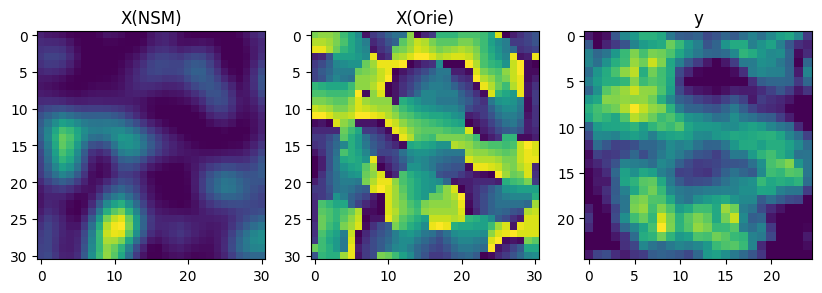

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.9611, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.9238, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3089, device='cuda:0') tensor(0.7559, device='cuda:0')


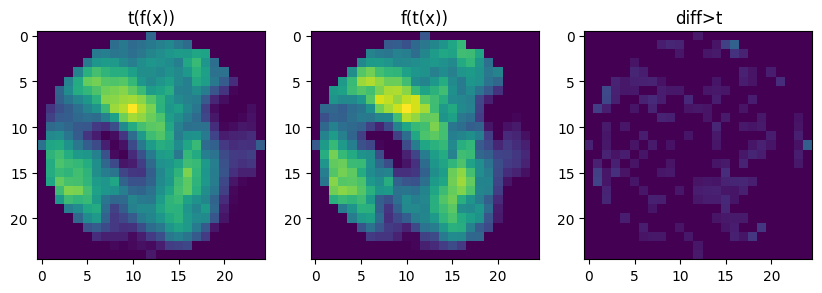

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.9316, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.8184, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.3163, device='cuda:0') tensor(0.7620, device='cuda:0')


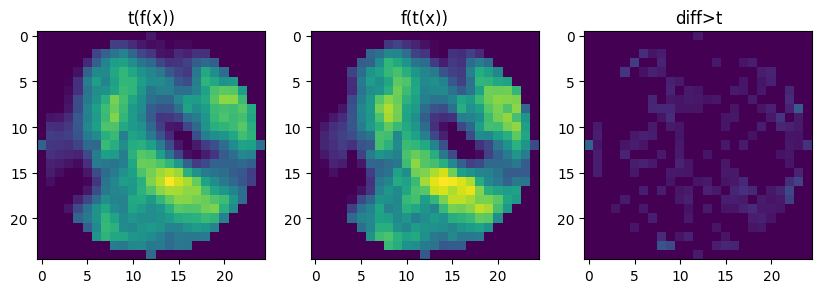

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.9067, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.9239, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1781, device='cuda:0') tensor(0.6809, device='cuda:0')


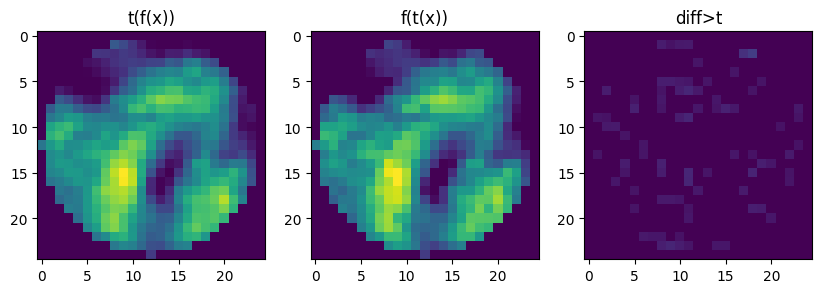

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0114, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.8592, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2481, device='cuda:0') tensor(0.6878, device='cuda:0')


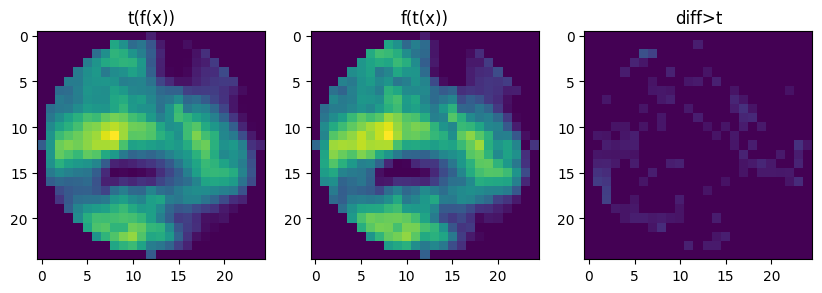

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.9015, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.9087, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1859, device='cuda:0') tensor(0.7236, device='cuda:0')


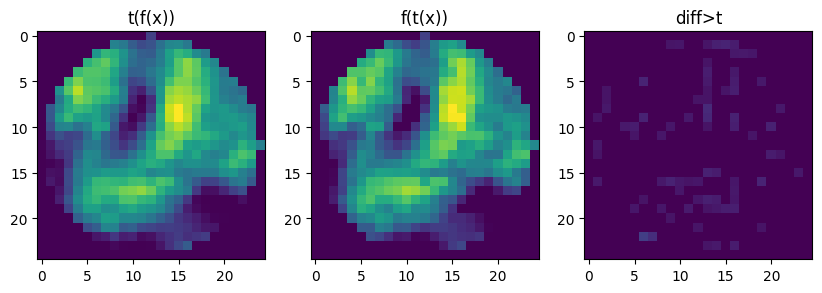

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.9303, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.9110, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1679, device='cuda:0') tensor(0.6795, device='cuda:0')


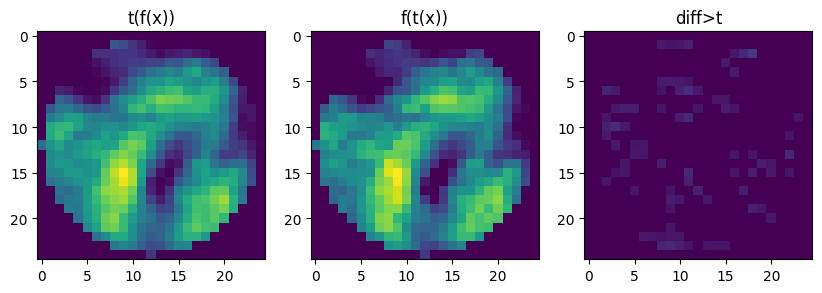

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.9415, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.8193, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1775, device='cuda:0') tensor(0.6813, device='cuda:0')


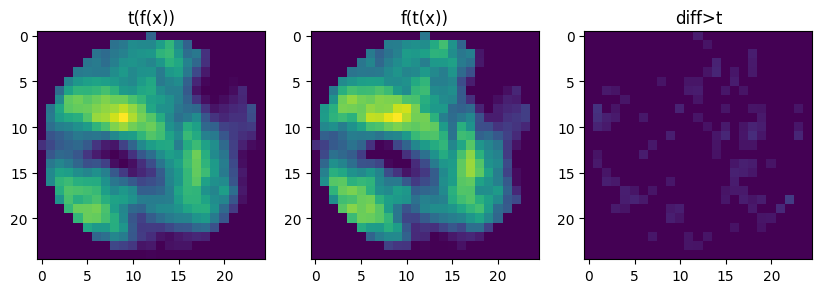

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0114, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(2.8592, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.2481, device='cuda:0') tensor(0.7232, device='cuda:0')


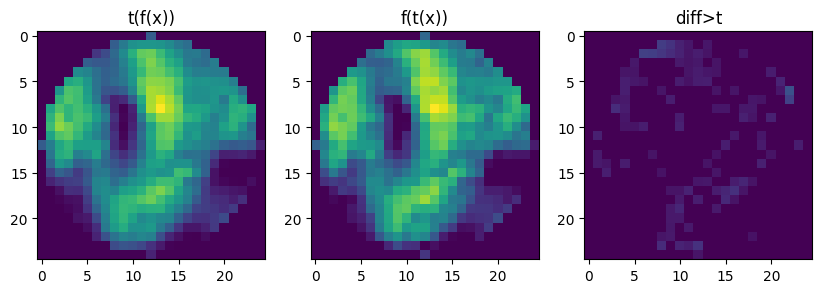

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0396, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0071, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1228, device='cuda:0') tensor(0.6888, device='cuda:0')


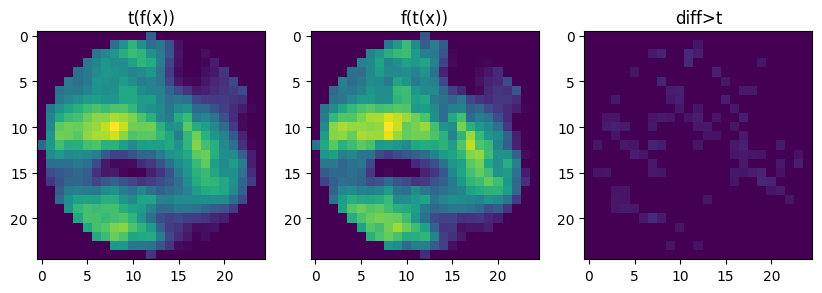

tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0460, device='cuda:0')
tensor(0., device='cuda:0') tensor(0., device='cuda:0') tensor(1., device='cuda:0') tensor(3.0239, device='cuda:0')
tensor(0., device='cuda:0') tensor(0.1203, device='cuda:0') tensor(0.6773, device='cuda:0')


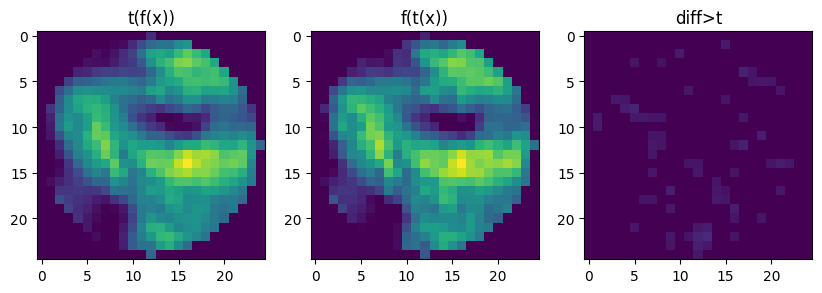

In [151]:
model_feature = model.feature
model_discriminator = model.discriminator

torch.manual_seed(42)
angles =  torch.tensor(np.random.uniform(low=0.0, high=360.0, size=10)//1, dtype=torch.float32).to(device)



iterator=iter(test_loader)
data = next(iterator)
index = 5 
with torch.no_grad():
    y = model_feature(data)
    c_mask = create_circular_mask(y.shape[2],y.shape[3])
    c_mask = torch.tensor(c_mask).to(device)

    show_images(normalize_tensor(data[index,0]),normalize_tensor(data[index,1]),normalize_tensor(y[index,0]),title1="X(NSM)",title2="X(Orie)",title3="y")
    for angle in angles:
        data_rotated, y_rotated = rotate_images(data, y, angle)
        y_rotated2 = model_feature(data_rotated)
        
        distance =model_discriminator(y_rotated,y_rotated2)
        y_rotated2 = y_rotated2*c_mask
        y_rotated = y_rotated*c_mask

        y1n=normalize_tensor(y_rotated[0,0])
        y2n=normalize_tensor(y_rotated2[0,0])

        print(y1n.min(),y_rotated.min(),y1n.max(),y_rotated.max())
        print(y2n.min(),y_rotated2.min(),y2n.max(),y_rotated2.max())
        
        diff = abs(y2n - y1n)
        t = 0.05
        diff[abs(diff) < t] = 0

        print(diff.min(),diff.max(),distance[0])
        show_images(y1n,y2n,diff,title1="t(f(x))",title2="f(t(x))",title3="diff>t")

In [152]:
def copy_tensor(tensor,times):
    tensor = tensor.repeat(times,1,1,1)
    return tensor

size = len(data)
with torch.no_grad():
  for i in range(size):
    img_temp = data[i][None]
    data_temp = copy_tensor(img_temp,size)

    # print(img_temp.shape,data_temp.shape)
    distances = model(data_temp,data)
    print(distances)
    print("index: ",i," found in ",distances.argmin().item()," position ")

tensor([0.6775, 0.8283, 0.9114, 0.9017, 0.9494, 0.9179, 0.9119, 0.9342, 0.9571,
        0.9413], device='cuda:0')
index:  0  found in  0  position 
tensor([0.8472, 0.7085, 0.9376, 0.8601, 0.9239, 0.9218, 0.9362, 0.9172, 0.9508,
        0.9653], device='cuda:0')
index:  1  found in  1  position 
tensor([0.9213, 0.9438, 0.6978, 0.9264, 0.9618, 0.9666, 0.9590, 0.9655, 0.9549,
        0.9565], device='cuda:0')
index:  2  found in  2  position 
tensor([0.9131, 0.8912, 0.9231, 0.6970, 0.9512, 0.9569, 0.9434, 0.9525, 0.9478,
        0.9731], device='cuda:0')
index:  3  found in  3  position 
tensor([0.9550, 0.9388, 0.9617, 0.9421, 0.6650, 0.9669, 0.9686, 0.9060, 0.9810,
        0.9810], device='cuda:0')
index:  4  found in  4  position 
tensor([0.9240, 0.9112, 0.9697, 0.9603, 0.9702, 0.6801, 0.9618, 0.9746, 0.9854,
        0.9903], device='cuda:0')
index:  5  found in  5  position 
tensor([0.9250, 0.9490, 0.9590, 0.9423, 0.9708, 0.9675, 0.6951, 0.9423, 0.9814,
        0.9572], device='cuda:0'

In [153]:
c_mask = create_circular_mask(data.shape[2],data.shape[3])
c_mask = torch.tensor(c_mask).to(device)

dist = model(data*c_mask,data*c_mask)
print(dist.argmin().item(),dist)

t = torch.ones(10,2,31,31).to(device)
dist = model(data,t*c_mask)
print(dist.argmin().item(),dist)

4 tensor([0.6774, 0.7085, 0.6976, 0.6970, 0.6650, 0.6801, 0.6951, 0.6860, 0.6687,
        0.6741], device='cuda:0', grad_fn=<SigmoidBackward0>)
9 tensor([0.9768, 0.9857, 0.9840, 0.9876, 0.9951, 0.9954, 0.9870, 0.9895, 0.9804,
        0.9703], device='cuda:0', grad_fn=<SigmoidBackward0>)


tensor(0., device='cuda:0') tensor(8.9101, device='cuda:0') tensor(1.5536, device='cuda:0')
tensor(0., device='cuda:0') tensor(8., device='cuda:0') tensor(1.1290, device='cuda:0')


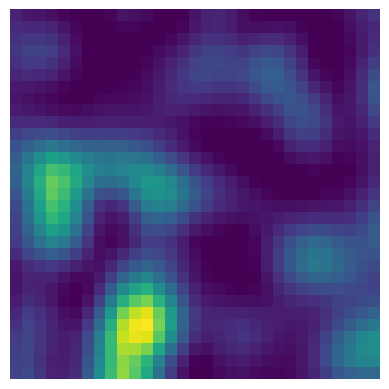

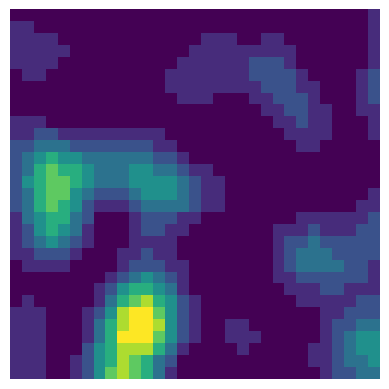

In [179]:
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# Carregar a imagem em tons de cinza como um tensor
gray_image = data[5,0]

# Reduzir a quantidade de cores para 16
num_colors = 9
print(gray_image.min(),gray_image.max(),gray_image.mean())
quantized_image = torch.floor_divide(gray_image, 9 // num_colors) * (9 // num_colors)
print(quantized_image.min(),quantized_image.max(),quantized_image.mean())


plt.imshow(gray_image.cpu().numpy())
plt.axis('off')
plt.show()
# Mostrar a imagem quantizada
plt.imshow(quantized_image.cpu().numpy())
plt.axis('off')
plt.show()


In [181]:
import torch
import torchvision.transforms as transforms

# Crie um tensor de exemplo
tensor = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])

# Normalize o tensor entre 0 e 1
normalized_tensor =  torch.nn.functional.normalize(tensor, p=2, dim=0)
normalized_tensor2 = torch.norm(tensor, p=2, dim=0)
print("Tensor normalizado:", normalized_tensor,normalized_tensor2)


Tensor normalizado: tensor([0.1348, 0.2697, 0.4045, 0.5394, 0.6742]) tensor(7.4162)
